<a href="https://colab.research.google.com/github/mili189/ASK2026_Semiconductor_FDC/blob/main/%EA%B7%9C%EC%88%9C/%20LSTM_AE%2C_TranAD%2C_1D_ResNet_%ED%86%B5%ED%95%A9_%EB%AA%A8%EB%8D%B8_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os


drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ==========================================
# 1. 라이브러리 임포트 및 설정
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score
import os
import math

# CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. 데이터 로드
# ==========================================
# 업로드된 파일명 사용 (환경에 맞게 경로 수정 가능)
file_path = ("/content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx")

if os.path.exists(file_path):
    print(f"Loading data from: {file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
else:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    # 임시 빈 데이터프레임 생성 (에러 방지용)
    df = pd.DataFrame()

# 센서 컬럼 정의
sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

# ==========================================
# 3. 데이터 전처리 함수
# ==========================================
"""
    Wafer_ID 별로 그룹화하여 슬라이딩 윈도우를 적용하는 함수

    Args:
        df_target: 대상 데이터프레임
        wafer_col: Wafer ID 컬럼명
        sensor_cols: 센서 데이터 컬럼 리스트
        seq_len: 윈도우 크기
        scaler: 사용할 스케일러 (None이면 새로 생성)
        is_train: 학습 모드 여부 (True면 fit_transform, False면 transform)

    Returns:
        X_all: (N, seq_len, n_features) 형태의 numpy 배열
        scaler: 학습/사용된 스케일러
"""
def create_sequences_per_wafer(df_target, wafer_col, sensor_cols, seq_len, scaler=None, is_train=True):

    # 1. 스케일링 처리
    # (Wafer별로 따로 스케일링하면 Wafer 간의 상대적 크기 정보가 사라질 수 있으므로 전체 기준으로 합니다.)
    data_values = df_target[sensor_cols].values

    if is_train:
        # 학습용: Scaler 생성 및 학습
        if scaler is None:
            scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_values)
    else:
        # 테스트용: 기존 Scaler 사용
        if scaler is None:
            raise ValueError("Test mode requires a fitted scaler.")
        data_scaled = scaler.transform(data_values)

    # 스케일링 된 데이터를 다시 DataFrame에 맵핑 (Wafer ID로 그룹핑하기 위해)
    df_scaled = pd.DataFrame(data_scaled, columns=sensor_cols, index=df_target.index)
    df_scaled[wafer_col] = df_target[wafer_col].values

    all_sequences = []

    # 2. Wafer ID 별로 슬라이딩 윈도우 적용
    unique_wafers = df_scaled[wafer_col].unique()

    for wafer in unique_wafers:
        # 특정 Wafer 데이터 추출
        wafer_data = df_scaled[df_scaled[wafer_col] == wafer][sensor_cols].values

        # 데이터가 윈도우 크기보다 작으면 스킵
        if len(wafer_data) < seq_len:
            continue

        # 슬라이딩 윈도우 생성
        for i in range(len(wafer_data) - seq_len + 1):
            all_sequences.append(wafer_data[i : i + seq_len])

    if len(all_sequences) == 0:
        return np.array([]), scaler

    return np.array(all_sequences), scaler

# ==========================================
# 4. 데이터셋 구성 (실험별 루프)
# ==========================================
experiments = ['l29', 'l31', 'l33']
datasets = {}

print("\n--- Preprocessing Data (Per Wafer Logic) ---")

for exp_id in experiments:
    print(f"\nProcessing Experiment: {exp_id}")

    # 1. 해당 실험 데이터 추출
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]

    if exp_df.empty:
        print(f"No data for {exp_id}")
        continue

    # 2. Wafer ID 추출 및 분할 (Label 기준)
    # 정상 Wafer와 불량 Wafer의 ID 리스트를 확보
    normal_wafer_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
    fault_wafer_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

    print(f"  - Total Normal Wafers: {len(normal_wafer_ids)}")
    print(f"  - Total Fault Wafers: {len(fault_wafer_ids)}")

    # 정상 Wafer가 너무 적으면 스킵
    if len(normal_wafer_ids) < 4:
        print("  - Not enough normal wafers to split.")
        continue

    # 3. Train / Test Split (Wafer ID 기준)
    # 정상 Wafer 중 80%는 학습용, 20%는 테스트용
    n_train_wafers = int(len(normal_wafer_ids) * 0.8)

    train_wafer_ids = normal_wafer_ids[:n_train_wafers]
    test_norm_wafer_ids = normal_wafer_ids[n_train_wafers:]

    # ID를 기준으로 데이터프레임 필터링
    train_df = exp_df[exp_df['Wafer_ID'].isin(train_wafer_ids)]
    test_norm_df = exp_df[exp_df['Wafer_ID'].isin(test_norm_wafer_ids)]
    test_fault_df = exp_df[exp_df['Wafer_ID'].isin(fault_wafer_ids)]

    # 4. 슬라이딩 윈도우 파라미터 설정
    SEQ_LEN = 10

    # (1) Train Data: Fit & Transform
    # 여기서 만들어진 scaler를 반환받아 테스트셋에 적용합니다.
    X_train, scaler = create_sequences_per_wafer(
        train_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=None, is_train=True
    )

    # (2) Test Normal Data: Transform Only
    X_test_normal, _ = create_sequences_per_wafer(
        test_norm_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False     # 학습 데이터로 변환한 Scaler 적용
    )

    # (3) Test Fault Data: Transform Only
    if not test_fault_df.empty:
        X_test_fault, _ = create_sequences_per_wafer(
            test_fault_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False    # 학습 데이터로 변환한 Scaler 적용
        )
    else:
        X_test_fault = np.array([])

    # 5. 결과 저장
    datasets[exp_id] = {
        'X_train': X_train,
        'X_test_norm': X_test_normal,
        'X_test_fault': X_test_fault,
        'scaler': scaler
    }

    print(f"  -> [{exp_id}] Result Shapes:")
    print(f"     X_train     : {X_train.shape}")
    print(f"     X_test_norm : {X_test_normal.shape}")
    print(f"     X_test_fault: {X_test_fault.shape}")

print("\nData preprocessing completed.")


Loading data from: /content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx

--- Preprocessing Data (Per Wafer Logic) ---

Processing Experiment: l29
  - Total Normal Wafers: 34
  - Total Fault Wafers: 9
  -> [l29] Result Shapes:
     X_train     : (2546, 10, 19)
     X_test_norm : (634, 10, 19)
     X_test_fault: (832, 10, 19)

Processing Experiment: l31
  - Total Normal Wafers: 37
  - Total Fault Wafers: 6
  -> [l31] Result Shapes:
     X_train     : (2589, 10, 19)
     X_test_norm : (722, 10, 19)
     X_test_fault: (488, 10, 19)

Processing Experiment: l33
  - Total Normal Wafers: 37
  - Total Fault Wafers: 6
  -> [l33] Result Shapes:
     X_train     : (2607, 10, 19)
     X_test_norm : (706, 10, 19)
     X_test_fault: (550, 10, 19)

Data preprocessing completed.


In [5]:
# ==========================================
# 1. 데이터 로드 함수 (수정됨)
# ==========================================
def get_data_loaders(exp_id, datasets, batch_size=32):
    print(f"\n📊 [Data Setup] Experiment: {exp_id}")

    # 이미 전처리 단계에서 Wafer_ID 별로 완벽하게 분할된 데이터를 가져옵니다.
    data = datasets[exp_id]
    X_train = data['X_train']
    X_test_norm = data['X_test_norm']
    X_test_fault = data['X_test_fault']

    print(f"   - Train (Normal): {X_train.shape}")
    print(f"   - Test Normal   : {X_test_norm.shape}")
    print(f"   - Test Fault    : {X_test_fault.shape}")

    # 1. Tensor 변환
    train_tensor = torch.FloatTensor(X_train).to(device)
    test_norm_tensor = torch.FloatTensor(X_test_norm).to(device)

    # Fault 데이터가 없는 경우(혹시 모를 예외) 처리
    if len(X_test_fault) > 0:
        test_fault_tensor = torch.FloatTensor(X_test_fault).to(device)
    else:
        test_fault_tensor = torch.FloatTensor([]).to(device)

    # 2. DataLoader 생성 (Train만 셔플)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)

    return train_loader, test_norm_tensor, test_fault_tensor

# ==========================================
# 2. 결과 시각화 함수 (기존 유지)
# ==========================================
def visualize_results(model_name, exp_id, scores, labels, threshold):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] {model_name} Performance Analysis", fontsize=16, fontweight='bold')

    # --- Plot 1: Confusion Matrix ---
    preds = (scores > threshold).astype(int)
    cm = confusion_matrix(labels, preds)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'], annot_kws={"size": 14})
    axes[0].set_title("Confusion Matrix", fontsize=14)
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # --- Plot 2: Anomaly Scores ---
    axes[1].plot(scores, label='Score', color='black', alpha=0.7, linewidth=1)
    axes[1].axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.4f})')

    # 불량 구간 시각화
    fault_indices = np.where(labels == 1)[0]
    if len(fault_indices) > 0:
        start_idx = fault_indices[0]
        end_idx = fault_indices[-1]
        axes[1].axvspan(start_idx, end_idx, color='red', alpha=0.2, label='Actual Fault')

    axes[1].set_title("Anomaly Scores", fontsize=14)
    axes[1].set_xlabel("Sample Index")
    axes[1].set_ylabel("Reconstruction Error")
    axes[1].legend(loc='upper left')

    # --- Plot 3: ROC Curve ---
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title("ROC Curve", fontsize=14)
    axes[2].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==========================================
# 3. 공통 평가 함수 (기존 유지)
# ==========================================
def evaluate_performance(model_name, exp_id, scores, labels):
    # Best F1 Score를 기준으로 Threshold 자동 계산
    precision, recall, thresholds = precision_recall_curve(labels, scores)

    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores) # NaN 처리

    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_thresh = thresholds[best_idx]

    # AUC 계산
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n📌 [{model_name} - {exp_id}] Result Summary")
    print(f"   - AUROC         : {roc_auc:.4f}")
    print(f"   - Best F1-Score : {best_f1:.4f}")
    print(f"   - Best Threshold: {best_thresh:.6f}")

    visualize_results(model_name, exp_id, scores, labels, best_thresh)
    return roc_auc, best_f1

In [6]:
# ==========================================
# Model-1 LSTM AE
# ==========================================
class LAM9600_LSTM_AE(nn.Module):
    def __init__(self, n_features, seq_len):
        super(LAM9600_LSTM_AE, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features

        # [Encoder] 입력 -> 64 -> 32 -> 16
        self.encoder_lstm1 = nn.LSTM(n_features, 64, batch_first=True)
        self.encoder_lstm2 = nn.LSTM(64, 32, batch_first=True)
        self.encoder_lstm3 = nn.LSTM(32, 16, batch_first=True)

        # [Decoder] 16 -> 32 -> 64 -> 입력
        self.decoder_lstm1 = nn.LSTM(16, 32, batch_first=True)
        self.decoder_lstm2 = nn.LSTM(32, 64, batch_first=True)
        self.output_layer = nn.Linear(64, n_features)

    def forward(self, x):
        _, _ = self.encoder_lstm1(x)
        enc1, _ = self.encoder_lstm1(x)
        enc2, _ = self.encoder_lstm2(enc1)
        _, (hidden, _) = self.encoder_lstm3(enc2) # Bottleneck (1, batch, 16)

        # Repeat Vector: 잠재 벡터를 시퀀스 길이만큼 복제
        repeat_x = hidden.repeat(self.seq_len, 1, 1).permute(1, 0, 2)

        dec1, _ = self.decoder_lstm1(repeat_x)
        dec2, _ = self.decoder_lstm2(dec1)
        return self.output_layer(dec2)

모델 입력 설정 완료: 시퀀스 길이=10, 센서 수=19

--- [l29] Training Baseline Model ---

📌 [Baseline - l29] Result Summary
   - AUROC         : 0.8690
   - Best F1-Score : 0.8117
   - Best Threshold: 0.012649


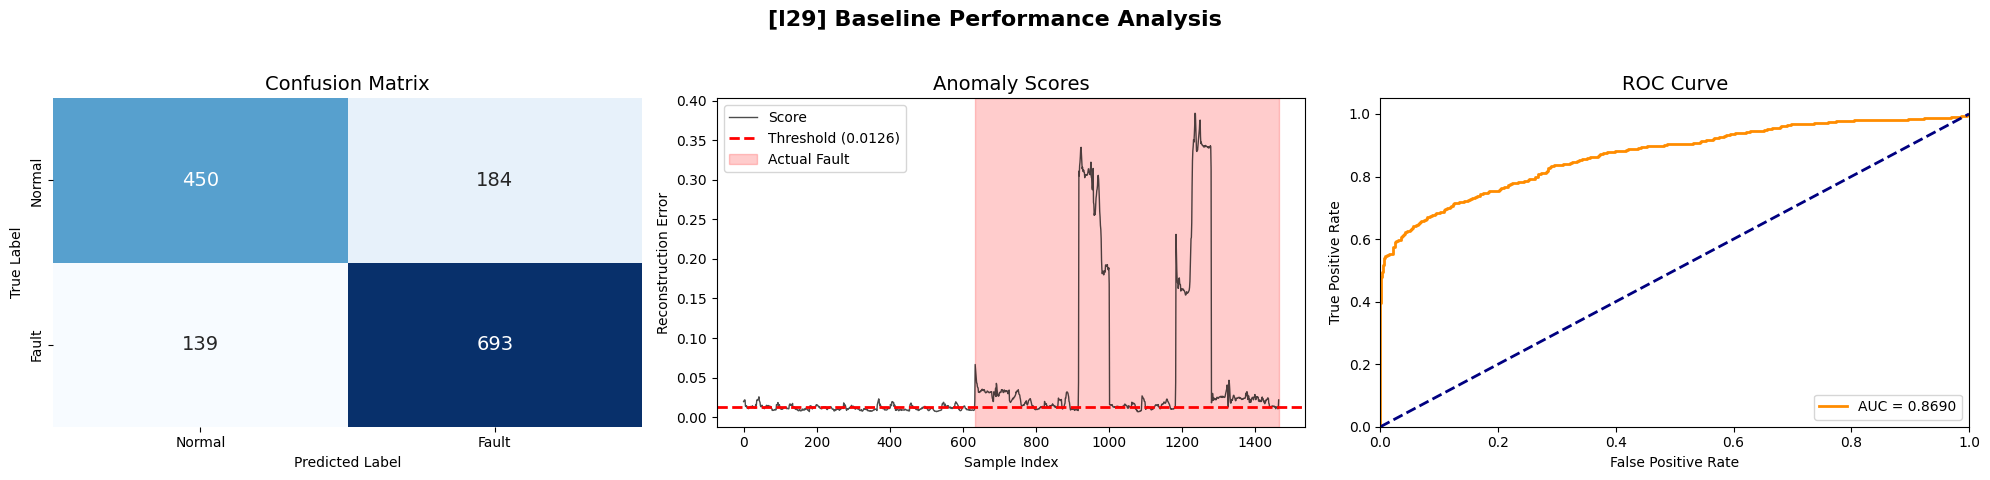


--- [l29] Training Proposed Model (Data Cleaning) ---
Cleaned Data Size: 2546 -> 2486

📌 [Proposed - l29] Result Summary
   - AUROC         : 0.8564
   - Best F1-Score : 0.7986
   - Best Threshold: 0.012019


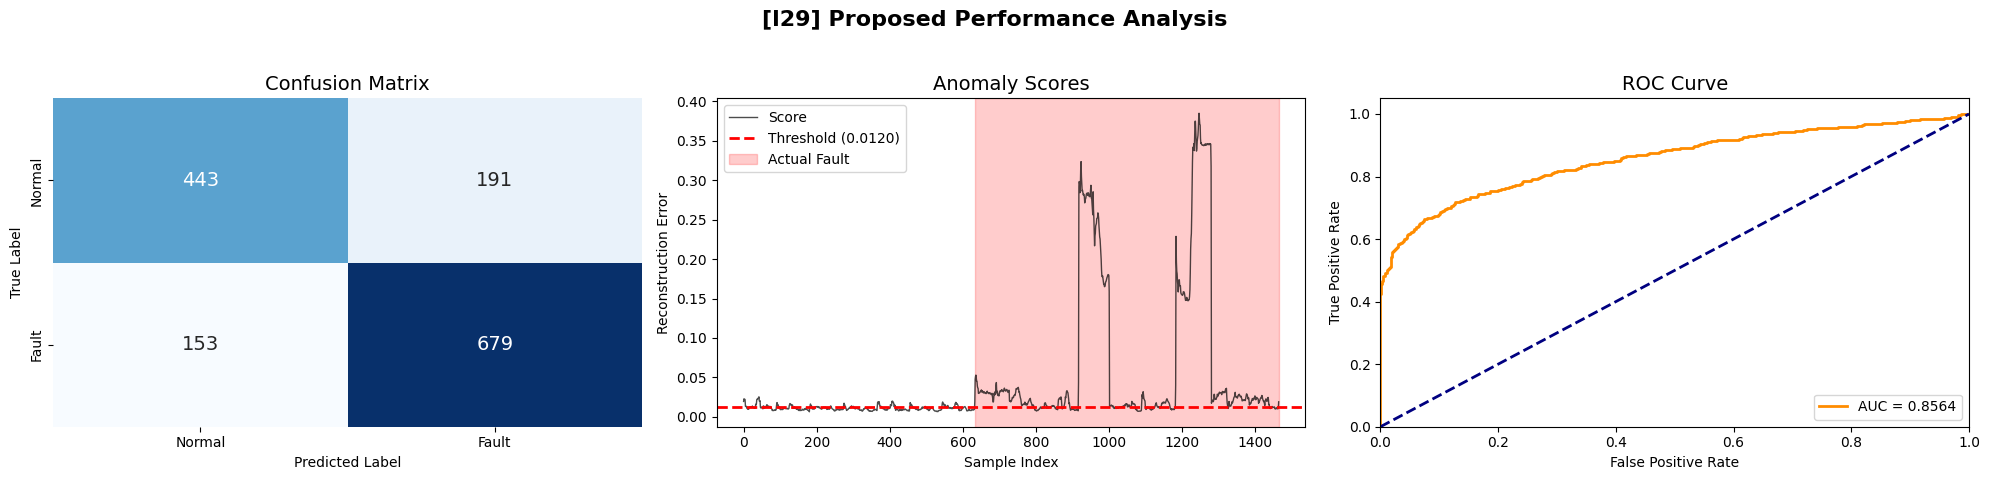


--- [l31] Training Baseline Model ---

📌 [Baseline - l31] Result Summary
   - AUROC         : 0.8185
   - Best F1-Score : 0.7253
   - Best Threshold: 0.016661


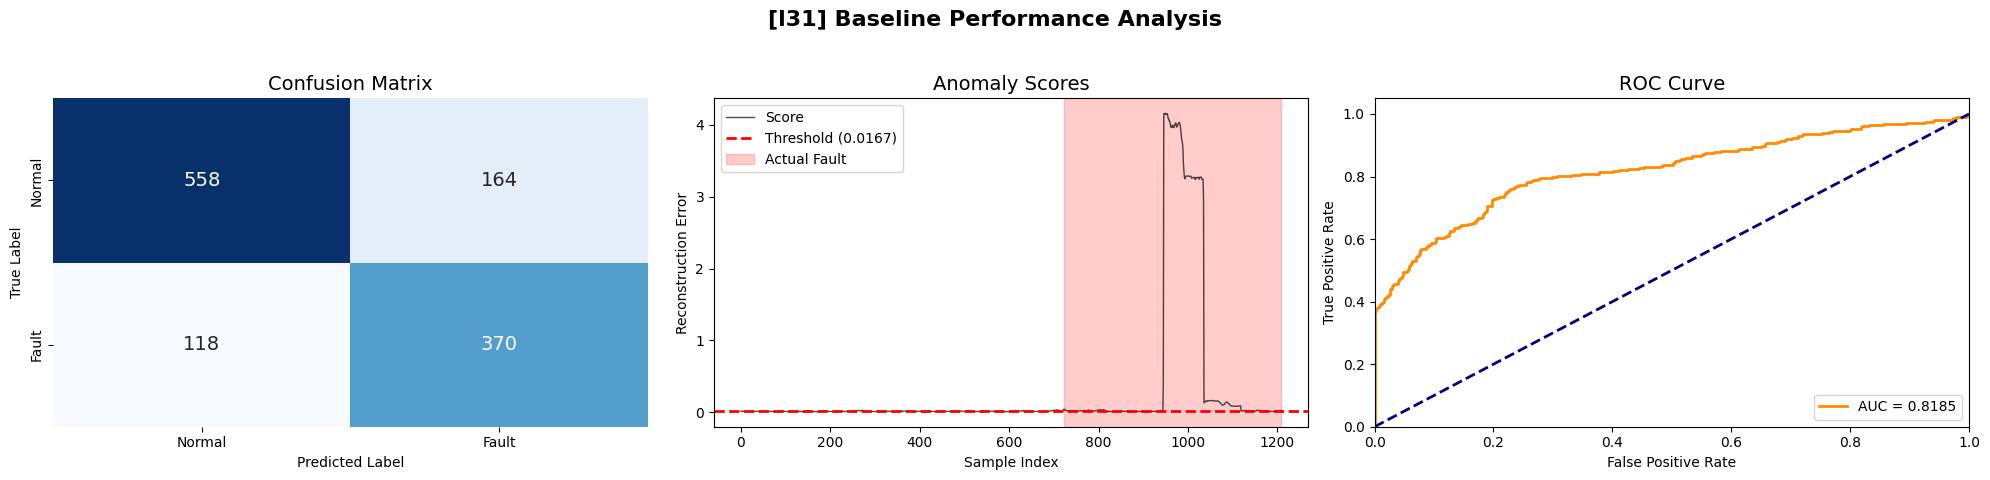


--- [l31] Training Proposed Model (Data Cleaning) ---
Cleaned Data Size: 2589 -> 2559

📌 [Proposed - l31] Result Summary
   - AUROC         : 0.8246
   - Best F1-Score : 0.7345
   - Best Threshold: 0.016107


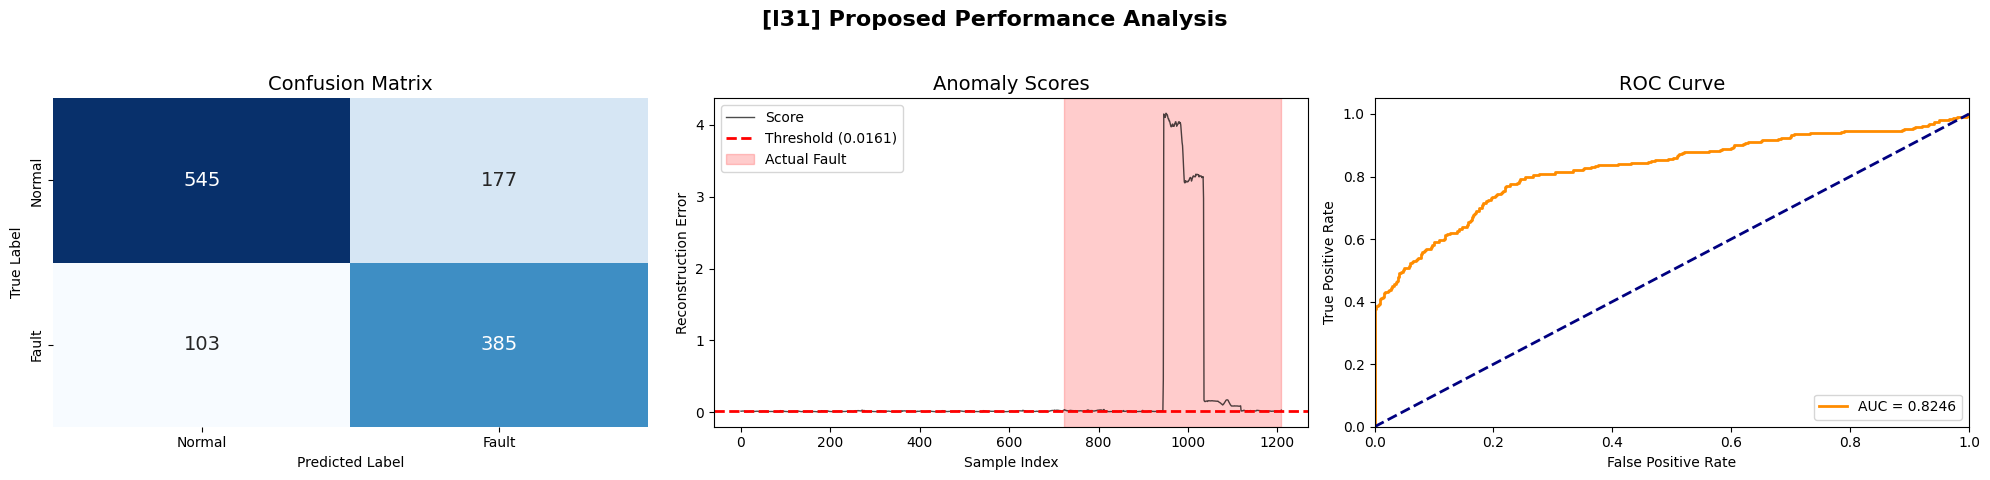


--- [l33] Training Baseline Model ---

📌 [Baseline - l33] Result Summary
   - AUROC         : 0.8922
   - Best F1-Score : 0.8046
   - Best Threshold: 0.015675


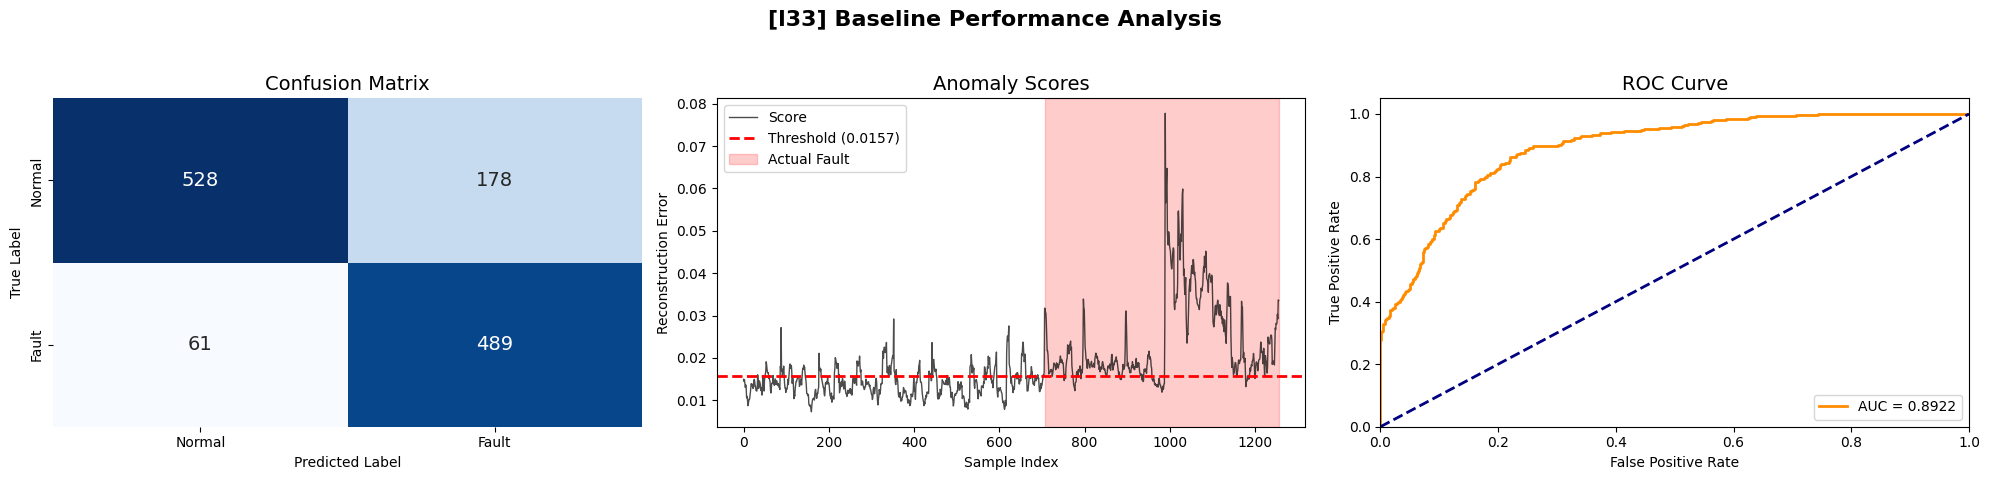


--- [l33] Training Proposed Model (Data Cleaning) ---
Cleaned Data Size: 2607 -> 2577

📌 [Proposed - l33] Result Summary
   - AUROC         : 0.9131
   - Best F1-Score : 0.8224
   - Best Threshold: 0.014284


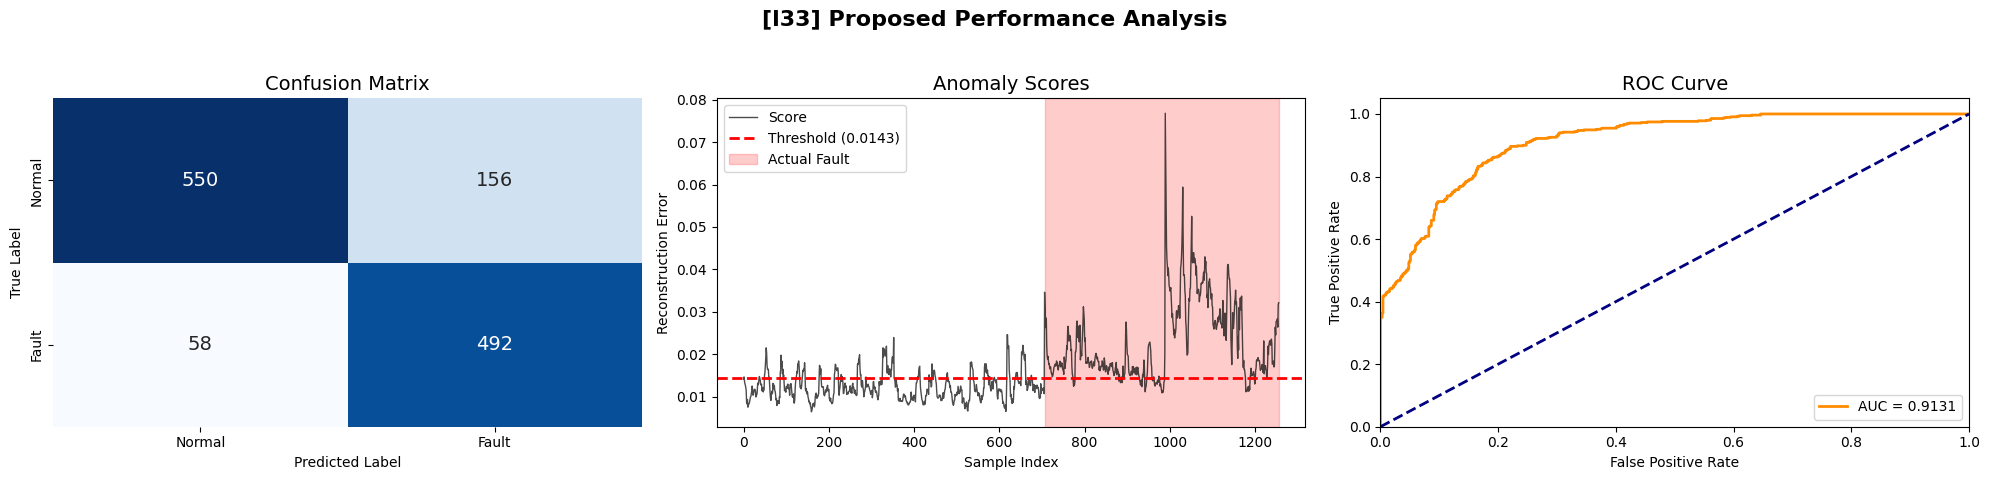


FINAL EXPERIMENT RESULTS
   Exp  Base_AUC   Base_F1   Pro_AUC    Pro_F1  Improve_AUC
0  l29  0.869043  0.811696  0.856385  0.798591    -0.012658
1  l31  0.818474  0.725318  0.824639  0.734539     0.006165
2  l33  0.892163  0.804598  0.913089  0.822352     0.020926


In [8]:
# 실험 설정
experiments = ['l29', 'l31', 'l33']
exp_configs = {
    'l29': {'clean_p': 98, 'thresh_p': 98, 'epochs': 100},
    'l31': {'clean_p': 99, 'thresh_p': 99, 'epochs': 100},
    'l33': {'clean_p': 99, 'thresh_p': 99, 'epochs': 100}
}
#exp_configs = {
#    'l29': {'clean_p': 85, 'thresh_p': 90, 'epochs': 50}, #제대로 작동되는지 보기 위해 에폭을 150에서 50으로 변경함.
#    'l31': {'clean_p': 95, 'thresh_p': 95, 'epochs': 50},
#    'l33': {'clean_p': 95, 'thresh_p': 95, 'epochs': 50}
#}
comparison_table = []

# --- 변수 정의 추가 ---
# 전처리된 데이터 중 하나(예: l29의 train 데이터)를 기준으로 형태를 파악합니다.
# 데이터 모양이 (샘플 수, 시퀀스 길이, 센서 수)이므로 인덱스 1과 2를 사용합니다.

sample_exp = experiments[0] # 'l29'
n_steps = datasets[sample_exp]['X_train'].shape[1] # 시퀀스 길이 (100)
n_feats = datasets[sample_exp]['X_train'].shape[2] # 센서 변수 개수

print(f"모델 입력 설정 완료: 시퀀스 길이={n_steps}, 센서 수={n_feats}")

for exp_id in experiments:
    if exp_id not in datasets: continue

    conf = exp_configs[exp_id]
    # 전처리된 데이터셋의 정확한 키(Key) 사용
    X_train_raw = datasets[exp_id]['X_train']
    X_test_normal = datasets[exp_id]['X_test_norm']
    X_test_fault = datasets[exp_id]['X_test_fault']

    # 평가를 위한 라벨 생성: Normal=0, Fault=1 (일반적인 이상탐지 기준)
    # 기존 코드의 y_true = [1]*norm + [0]*fault 구조는 Normal을 1로 잡고 있으나,
    # 통상적인 AUC 계산을 위해 Normal=0, Fault=1로 설정하는 것이 좋습니다.
    y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_fault))
    X_test_all = np.concatenate([X_test_normal, X_test_fault], axis=0)
    test_tensor = torch.FloatTensor(X_test_all).to(device)

    # --- [Case A] Baseline (정제 없음) ---
    print(f"\n--- [{exp_id}] Training Baseline Model ---")
    model_base = LAM9600_LSTM_AE(n_feats, n_steps).to(device)
    opt_base = optim.Adam(model_base.parameters(), lr=1e-3)
    train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_raw).to(device)), batch_size=16, shuffle=True)

    model_base.train()
    for epoch in range(50): # 시간을 위해 에폭 조절 가능
        for batch in train_loader:
            opt_base.zero_grad()
            output = model_base(batch[0])
            loss = nn.MSELoss()(output, batch[0])
            loss.backward()
            opt_base.step()

    model_base.eval()
    with torch.no_grad():
        # Reconstruction Error 계산
        reconstructed = model_base(test_tensor)
        # MSE score: (samples, seq_len, features) -> sample별 평균 오차
        ai_base = torch.mean((test_tensor - reconstructed)**2, dim=(1, 2)).cpu().numpy()

    # 평가 수행
    auc_base, f1_base = evaluate_performance("Baseline", exp_id, ai_base, y_true)

    # --- [Case B] Proposed (10-Fold CV 정제 포함) ---
    print(f"\n--- [{exp_id}] Training Proposed Model (Data Cleaning) ---")
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    bad_indices = []

    # 10-Fold Data Cleaning
    for t_idx, v_idx in kf.split(X_train_raw):
        temp_m = LAM9600_LSTM_AE(n_feats, n_steps).to(device)
        t_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_raw[t_idx]).to(device)), batch_size=16)
        temp_opt = optim.Adam(temp_m.parameters(), lr=1e-3)

        for _ in range(15):
            for b in t_loader:
                loss = nn.MSELoss()(temp_m(b[0]), b[0])
                temp_opt.zero_grad()
                loss.backward()
                temp_opt.step()

        with torch.no_grad():
            X_v = torch.FloatTensor(X_train_raw[v_idx]).to(device)
            ai_v = torch.mean((X_v - temp_m(X_v))**2, dim=(1, 2)).cpu().numpy()
            # 상위 n%를 이상치(노이즈)로 판단하여 제거 리스트에 추가
            thresh_val = np.percentile(ai_v, conf['clean_p'])
            bad_indices.extend(v_idx[ai_v > thresh_val])

    # 데이터 정제 및 재학습
    X_train_clean = np.delete(X_train_raw, list(set(bad_indices)), axis=0)
    print(f"Cleaned Data Size: {len(X_train_raw)} -> {len(X_train_clean)}")

    model_pro = LAM9600_LSTM_AE(n_feats, n_steps).to(device)
    opt_pro = optim.Adam(model_pro.parameters(), lr=1e-3)
    pro_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_clean).to(device)), batch_size=16, shuffle=True)

    model_pro.train()
    for epoch in range(conf['epochs']):
        for batch in pro_loader:
            opt_pro.zero_grad()
            loss = nn.MSELoss()(model_pro(batch[0]), batch[0])
            loss.backward()
            opt_pro.step()

    model_pro.eval()
    with torch.no_grad():
        reconstructed_pro = model_pro(test_tensor)
        ai_pro = torch.mean((test_tensor - reconstructed_pro)**2, dim=(1, 2)).cpu().numpy()

    # 평가 수행
    auc_pro, f1_pro = evaluate_performance("Proposed", exp_id, ai_pro, y_true)

    comparison_table.append({
        'Exp': exp_id,
        'Base_AUC': auc_base,
        'Base_F1': f1_base,
        'Pro_AUC': auc_pro,
        'Pro_F1': f1_pro,
        'Improve_AUC': auc_pro - auc_base
    })

# 결과 요약 표 출력
df_res = pd.DataFrame(comparison_table)
print("\n" + "="*50)
print("FINAL EXPERIMENT RESULTS")
print("="*50)
print(df_res)


🚀 [TranAD] Processing Experiment: l29


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


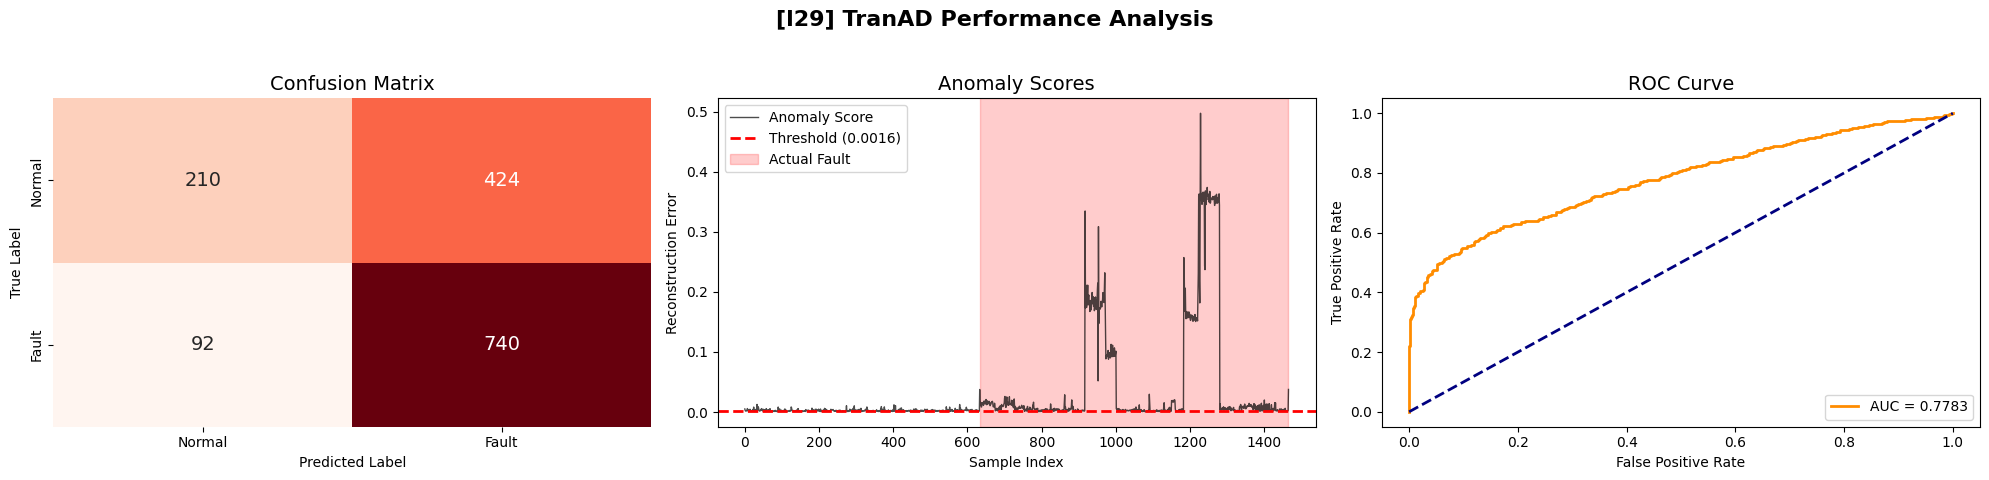


🚀 [TranAD] Processing Experiment: l31


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


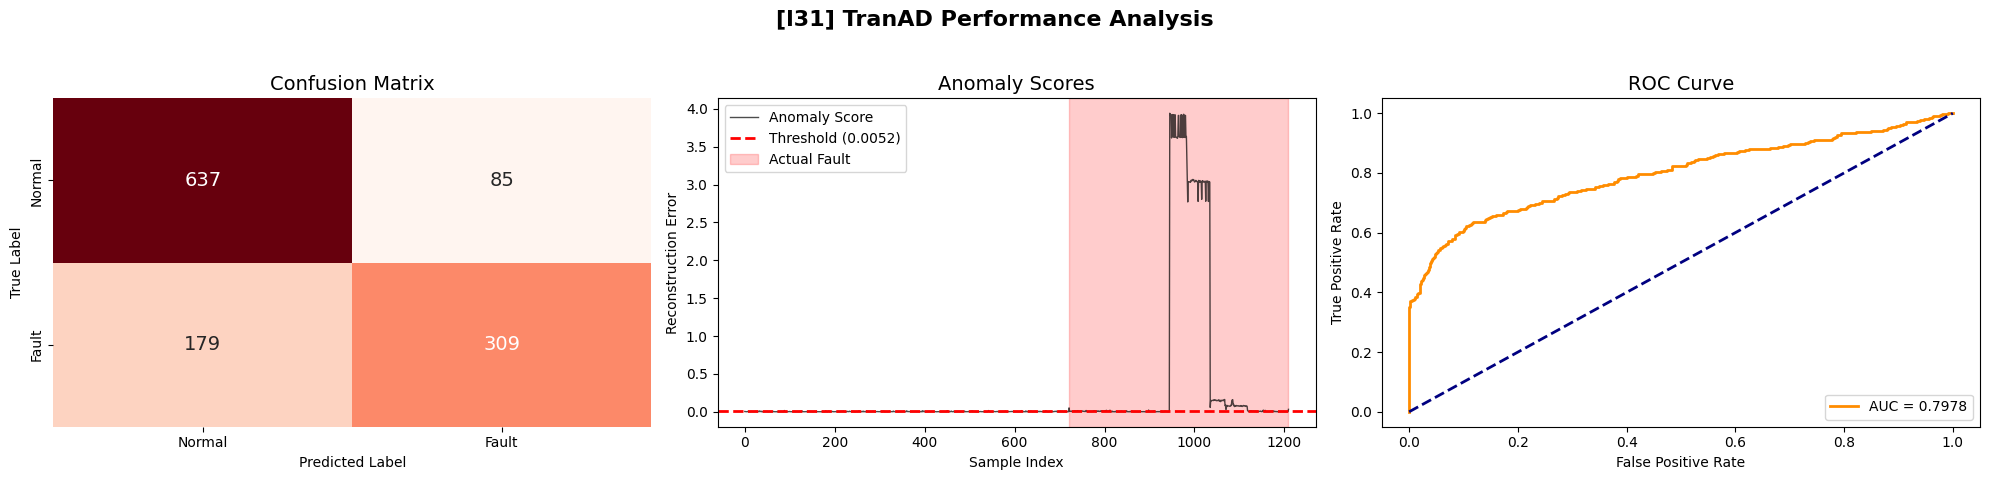


🚀 [TranAD] Processing Experiment: l33


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


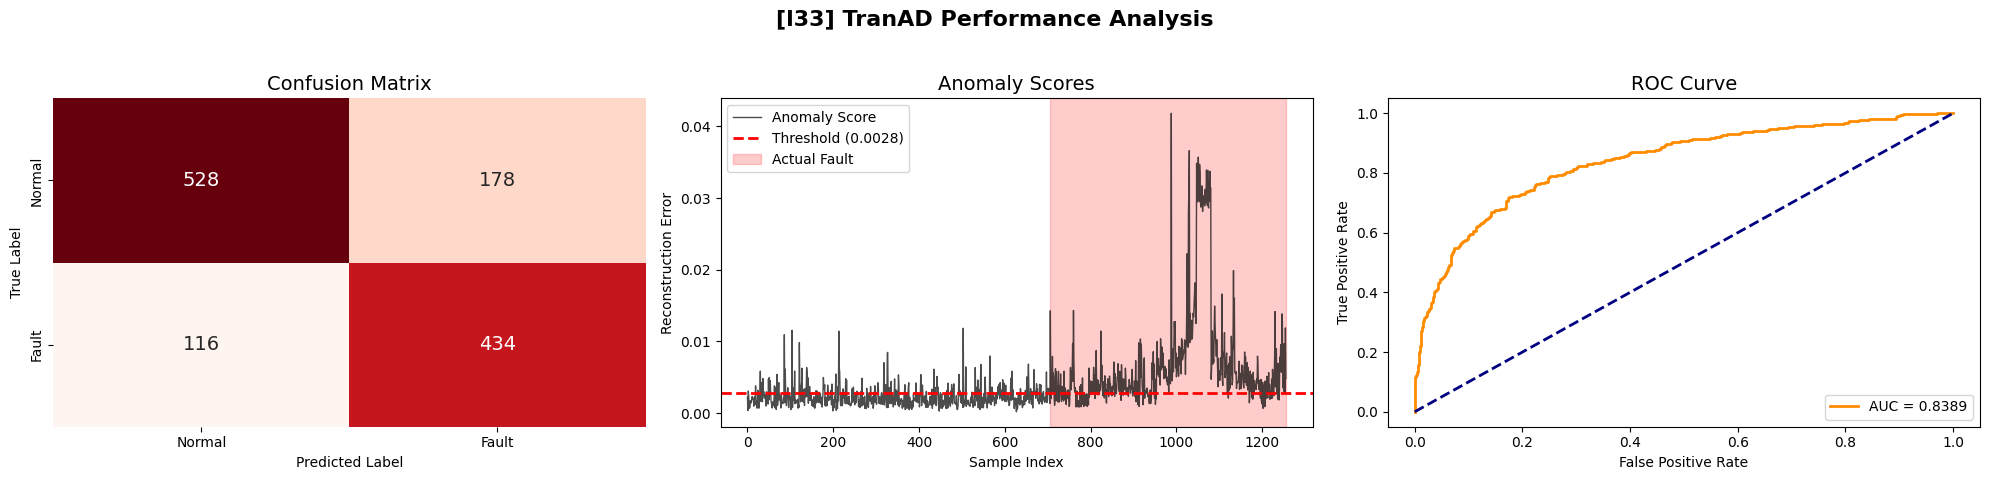


TranAD Final Summary
   Exp       AUC        F1
0  l29  0.778308  0.742113
1  l31  0.797846  0.702152
2  l33  0.838911  0.748065


In [9]:
# ==========================================
# Model-2 TranAD
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_recall_curve

# ==========================================
# 1. TranAD 모델 정의
# ==========================================
class TranAD(nn.Module):
    def __init__(self, n_feats, sequence_len):
        super(TranAD, self).__init__()
        self.n_feats = n_feats
        self.n_window = sequence_len
        self.batch_size = 128

        self.transformer = nn.Transformer(
            d_model=n_feats,
            nhead=1,            # 센서 수가 적을 때 안정적
            num_encoder_layers=1,
            num_decoder_layers=1,
            dim_feedforward=64,
            dropout=0.1,
            batch_first=True
        )
        self.pos_encoder = nn.Parameter(torch.randn(1, self.n_window, n_feats))
        self.fcn = nn.Sequential(nn.Linear(n_feats, n_feats), nn.Sigmoid())

    def forward(self, src, tgt):
        src = src + self.pos_encoder[:, :src.shape[1], :]
        out = self.transformer(src, tgt)
        return self.fcn(out)

# ==========================================
# 2. LSTM AE와 동일한 스타일의 시각화 함수
# ==========================================
def visualize_tranad_results(exp_id, scores, labels, threshold):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] TranAD Performance Analysis", fontsize=16, fontweight='bold')

    # --- Plot 1: Confusion Matrix ---
    preds = (scores > threshold).astype(int)
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axes[0],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'], annot_kws={"size": 14})
    axes[0].set_title("Confusion Matrix", fontsize=14)
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # --- Plot 2: Anomaly Scores (Time Series Style) ---
    axes[1].plot(scores, label='Anomaly Score', color='black', alpha=0.7, linewidth=1)
    axes[1].axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.4f})')

    # 불량 구간 시각화 (Label이 1인 구간)
    fault_indices = np.where(labels == 1)[0]
    if len(fault_indices) > 0:
        # 연속된 구간 표시를 위해 시작과 끝 탐색
        axes[1].axvspan(fault_indices[0], fault_indices[-1], color='red', alpha=0.2, label='Actual Fault')

    axes[1].set_title("Anomaly Scores", fontsize=14)
    axes[1].set_xlabel("Sample Index")
    axes[1].set_ylabel("Reconstruction Error")
    axes[1].legend(loc='upper left')

    # --- Plot 3: ROC Curve ---
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title("ROC Curve", fontsize=14)
    axes[2].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==========================================
# 3. 학습 및 추론 통합 루프
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tranad_results = []

for exp_id in experiments:
    if exp_id not in datasets: continue

    print(f"\n🚀 [TranAD] Processing Experiment: {exp_id}")
    data = datasets[exp_id]
    X_train = data['X_train']
    X_test_norm = data['X_test_norm']
    X_test_fault = data['X_test_fault']

    n_samples, seq_len, n_feats = X_train.shape
    model = TranAD(n_feats=n_feats, sequence_len=seq_len).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # --- 학습 (Training) ---
    train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train)), batch_size=128, shuffle=True)
    model.train()
    for epoch in range(30):  # 빠른 확인을 위해 30회 설정
        for batch in train_loader:
            x = batch[0].to(device)
            src, tgt = x, x[:, -1, :].unsqueeze(1)

            optimizer.zero_grad()
            output = model(src, tgt)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()

    # --- 추론 (Inference) ---
    model.eval()
    X_test_all = np.concatenate([X_test_norm, X_test_fault], axis=0)
    y_true = np.concatenate([np.zeros(len(X_test_norm)), np.ones(len(X_test_fault))])

    test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test_all)), batch_size=128, shuffle=False)
    all_scores = []

    with torch.no_grad():
        for batch in test_loader:
            x = batch[0].to(device)
            src, tgt = x, x[:, -1, :].unsqueeze(1)
            output = model(src, tgt)
            # MSE per sample
            score = torch.mean((output - tgt)**2, dim=2).squeeze()
            if score.ndim == 0: all_scores.append(score.item())
            else: all_scores.extend(score.cpu().numpy())

    all_scores = np.array(all_scores)

    # --- 최적 Threshold 탐색 (Best F1 기준) ---
    precision, recall, thresholds = precision_recall_curve(y_true, all_scores)
    f1_scores = np.nan_to_num(2 * recall * precision / (recall + precision + 1e-9))
    best_thresh = thresholds[np.argmax(f1_scores)]

    # --- 시각화 호출 ---
    visualize_tranad_results(exp_id, all_scores, y_true, best_thresh)

    # 결과 저장
    tranad_results.append({
        'Exp': exp_id,
        'AUC': auc(roc_curve(y_true, all_scores)[0], roc_curve(y_true, all_scores)[1]),
        'F1': np.max(f1_scores)
    })

# 최종 요약
import pandas as pd
print("\n" + "="*30)
print("TranAD Final Summary")
print(pd.DataFrame(tranad_results))

In [11]:
# ==========================================
# Model-3 1D-ResNet
# ==========================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # 첫 번째 합성곱 층
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        # 두 번째 합성곱 층
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Shortcut 연결 (차원이 다를 경우 1x1 Conv로 맞춰줌)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # 잔차 연결 (Skip Connection)
        out = F.relu(out)
        return out

class ResNet1D(nn.Module):
    def __init__(self, n_features, num_classes=1):
        super(ResNet1D, self).__init__()

        # 1. 초기 Convolution Layer (64 filters, kernel 3, stride 1)
        self.conv1 = nn.Conv1d(n_features, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(64)

        # 2. Spatial Dropout (PyTorch에서는 Dropout1d 사용)
        self.dropout1 = nn.Dropout1d(p=0.1)

        # 3. Residual Blocks
        # - Two identity blocks with 64 filters
        self.block1 = ResidualBlock(64, 64, stride=1)
        self.block2 = ResidualBlock(64, 64, stride=1)

        # - One convolution block (128 filters, stride 2 -> Downsampling)
        self.block3 = ResidualBlock(64, 128, stride=2)

        # - One identity block with 128 filters
        self.block4 = ResidualBlock(128, 128, stride=1)

        # 4. Global Average Pooling & Classification
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 100) # Dense layer with 100 units
        self.dropout2 = nn.Dropout(p=0.1)
        self.out = nn.Linear(100, num_classes)

    def forward(self, x):
        # 입력 차원 변경: (Batch, Seq, Feat) -> (Batch, Feat, Seq)
        x = x.transpose(1, 2)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)

        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1) # Flatten

        out = F.relu(self.fc(out))
        out = self.dropout2(out)
        out = torch.sigmoid(self.out(out)) # 이진 분류 (0~1)
        return out

print("✅ 1D ResNet Model Implementation Complete.")

✅ 1D ResNet Model Implementation Complete.


Using Device: cpu

🚀 [1D ResNet] Processing Experiment: l29
  Epoch [10/50], Loss: 0.038015
  Epoch [20/50], Loss: 0.025259
  Epoch [30/50], Loss: 0.002510
  Epoch [40/50], Loss: 0.022580
  Epoch [50/50], Loss: 0.001845


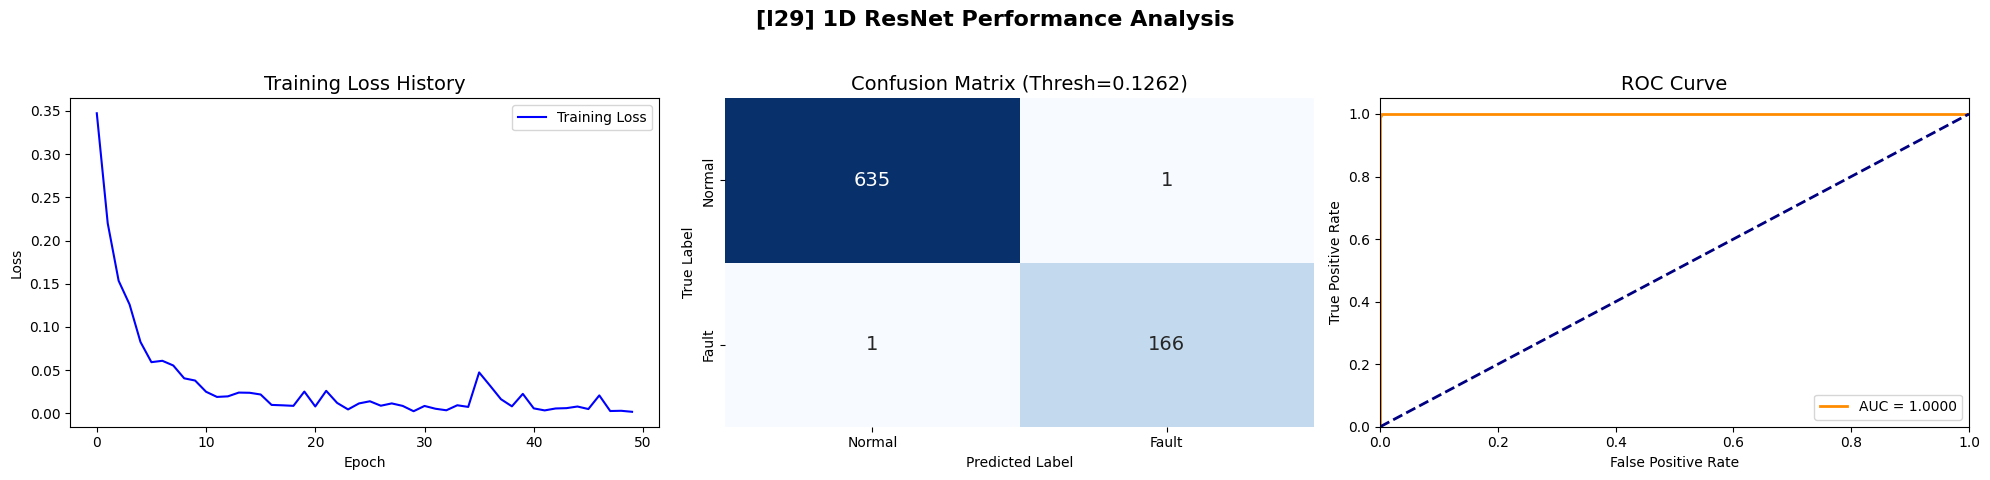


🚀 [1D ResNet] Processing Experiment: l31
  Epoch [10/50], Loss: 0.023460
  Epoch [20/50], Loss: 0.001908
  Epoch [30/50], Loss: 0.004078
  Epoch [40/50], Loss: 0.009372
  Epoch [50/50], Loss: 0.002854


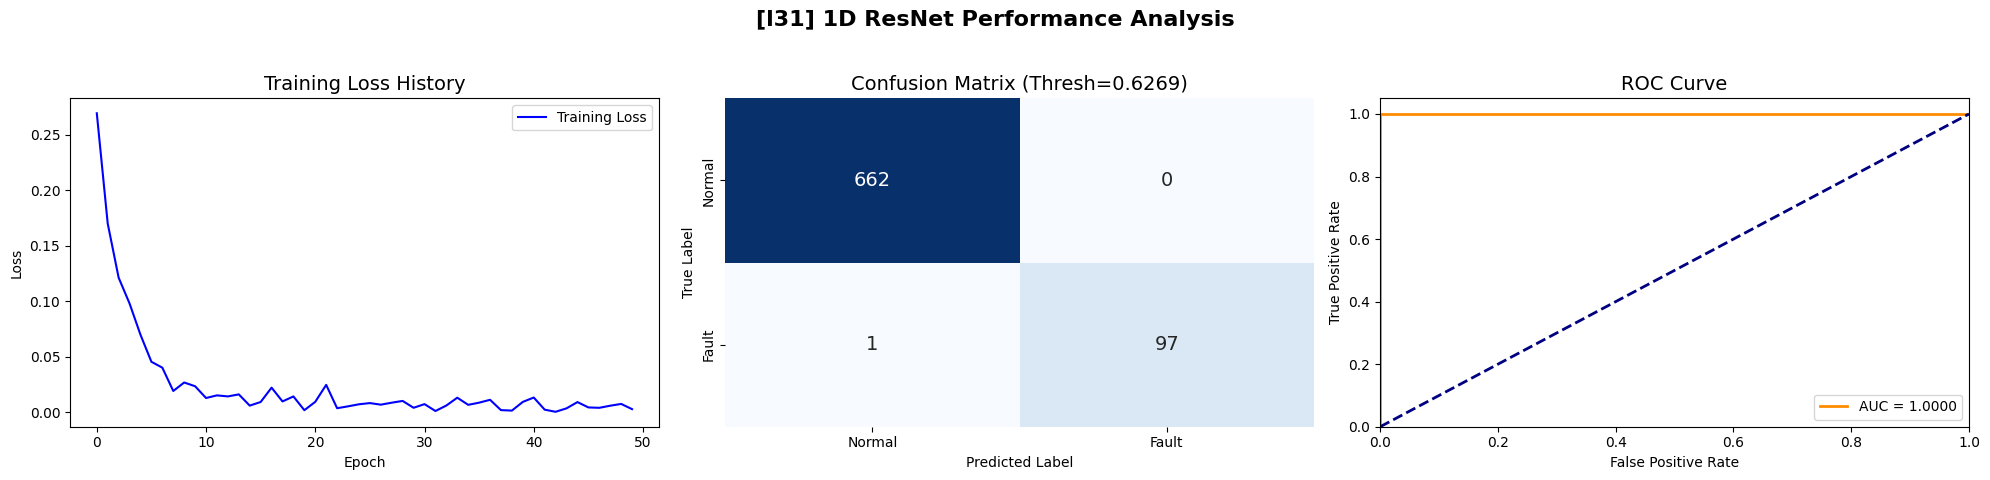


🚀 [1D ResNet] Processing Experiment: l33
  Epoch [10/50], Loss: 0.022875
  Epoch [20/50], Loss: 0.001507
  Epoch [30/50], Loss: 0.000684
  Epoch [40/50], Loss: 0.005483
  Epoch [50/50], Loss: 0.002051


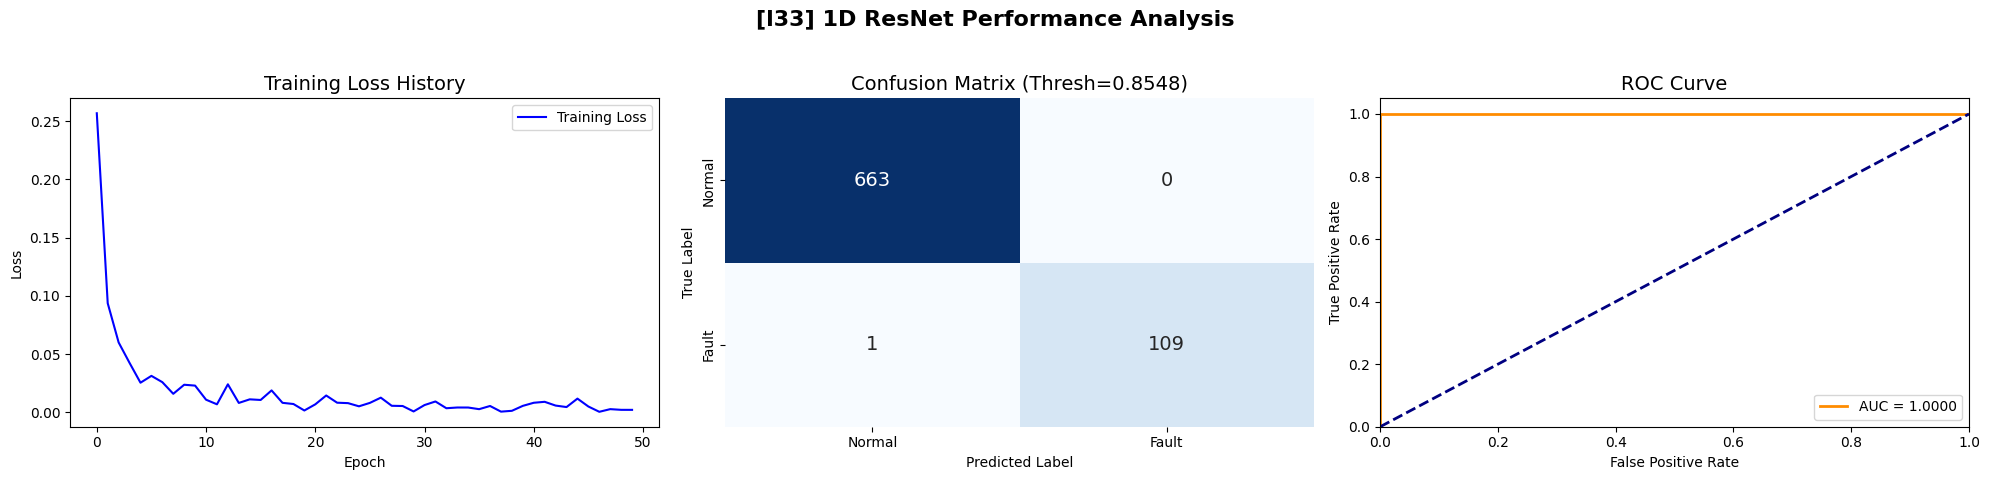


1D ResNet Final Results Summary
   Exp       AUC  F1_Score  F_Weighted  Best_Thresh
0  l29  0.999991  0.997015    0.997509     0.126179
1  l31  1.000000  1.000000    0.998681     0.626921
2  l33  1.000000  1.000000    0.998704     0.854761


In [12]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# ==========================================
# 1. 시각화 함수 정의
# ==========================================
def visualize_resnet_results(exp_id, train_losses, y_true, y_scores, threshold):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] 1D ResNet Performance Analysis", fontsize=16, fontweight='bold')

    # --- Plot 1: Training Loss Curve ---
    axes[0].plot(train_losses, label='Training Loss', color='blue')
    axes[0].set_title("Training Loss History", fontsize=14)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Plot 2: Confusion Matrix ---
    y_pred = (y_scores > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'], annot_kws={"size": 14})
    axes[1].set_title(f"Confusion Matrix (Thresh={threshold:.4f})", fontsize=14)
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')

    # --- Plot 3: ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title("ROC Curve", fontsize=14)
    axes[2].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==========================================
# 2. 실행 루프 (Experiment 별)
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

resnet_results = []
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EPOCHS = 50          # 빠른 실행을 위해 50회로 설정 (필요시 조절)

for exp_id in experiments:
    if exp_id not in datasets: continue

    print(f"\n🚀 [1D ResNet] Processing Experiment: {exp_id}")
    data = datasets[exp_id]

    # 1. 기존 데이터 로드
    X_train_ae = data['X_train']      # Normal Only (LSTM-AE용)
    X_test_norm = data['X_test_norm'] # Normal Only
    X_test_fault = data['X_test_fault'] # Fault Only

    # 2. 지도학습(Supervised)을 위한 데이터 재구성
    # ResNet은 Normal과 Fault를 모두 학습해야 하므로 데이터를 합친 후 다시 나눕니다.
    # 전체 Normal 데이터
    X_all_normal = np.concatenate([X_train_ae, X_test_norm], axis=0)
    # 전체 Fault 데이터
    X_all_fault = X_test_fault

    # 라벨 생성 (Normal=0, Fault=1)
    y_all_normal = np.zeros(len(X_all_normal))
    y_all_fault = np.ones(len(X_all_fault))

    # 전체 데이터 병합
    X_total = np.concatenate([X_all_normal, X_all_fault], axis=0)
    y_total = np.concatenate([y_all_normal, y_all_fault], axis=0)

    # Train/Test 분할 (Stratified Split으로 비율 유지)
    # Fault 데이터가 적으므로 Stratified가 중요합니다.
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_total, y_total, test_size=0.2, stratify=y_total, random_state=42
        )
    except ValueError:
        print(f"  ⚠️ {exp_id}: 데이터가 너무 적어 분할할 수 없습니다. 스킵합니다.")
        continue

    # Tensor 변환
    train_tensor_x = torch.FloatTensor(X_train).to(device)
    train_tensor_y = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    test_tensor_x = torch.FloatTensor(X_test).to(device)

    # DataLoader 생성
    train_loader = DataLoader(TensorDataset(train_tensor_x, train_tensor_y), batch_size=BATCH_SIZE, shuffle=True)

    # 모델 초기화
    n_samples, seq_len, n_feats = X_train.shape
    model = ResNet1D(n_features=n_feats).to(device)

    criterion = nn.BCELoss() # Binary Cross Entropy
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # --- 학습 (Training) ---
    model.train()
    train_losses = []

    for epoch in range(EPOCHS):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch+1) % 10 == 0:
            print(f"  Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")

    # --- 추론 (Inference) ---
    model.eval()
    with torch.no_grad():
        y_probs = model(test_tensor_x).cpu().numpy().flatten() # Sigmoid 출력값 (0~1)

    # --- 평가 (Metrics & Threshold) ---
    # Precision-Recall Curve로 Best F1 Threshold 찾기
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    # 분모가 0이 되는 것을 방지하기 위해 1e-9 추가
    f1_scores = np.divide(2 * recall * precision, recall + precision + 1e-9)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx] if len(thresholds) > best_idx else 0.5
    best_f1 = f1_scores[best_idx]

    # AUC 계산
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # F-weighted Score 계산 (논문 지표)
    y_pred = (y_probs > best_thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    f1_fault = tp / (tp + 0.5 * (fp + fn) + 1e-9)
    f0_normal = tn / (tn + 0.5 * (fn + fp) + 1e-9)

    n_fault = np.sum(y_test == 1)
    n_normal = np.sum(y_test == 0)

    if (n_fault + n_normal) > 0:
        f_weighted = (f1_fault * n_fault + f0_normal * n_normal) / (n_fault + n_normal)
    else:
        f_weighted = 0.0

    resnet_results.append({
        'Exp': exp_id,
        'AUC': roc_auc,
        'F1_Score': best_f1,
        'F_Weighted': f_weighted,
        'Best_Thresh': best_thresh
    })

    # --- 시각화 ---
    visualize_resnet_results(exp_id, train_losses, y_test, y_probs, best_thresh)

# 결과 요약 출력
print("\n" + "="*50)
print("1D ResNet Final Results Summary")
print("="*50)
df_res = pd.DataFrame(resnet_results)
print(df_res)

Using Device: cpu

🚀 [1D ResNet] Processing Experiment: l29
  - Total Normal: 3180, Total Fault: 832
  - Resplit Train: (3209, 10, 19), Test: (803, 10, 19)
  Epoch [10/50], Loss: 0.047346
  Epoch [20/50], Loss: 0.014701
  Epoch [30/50], Loss: 0.019172
  Epoch [40/50], Loss: 0.003953
  Epoch [50/50], Loss: 0.002753


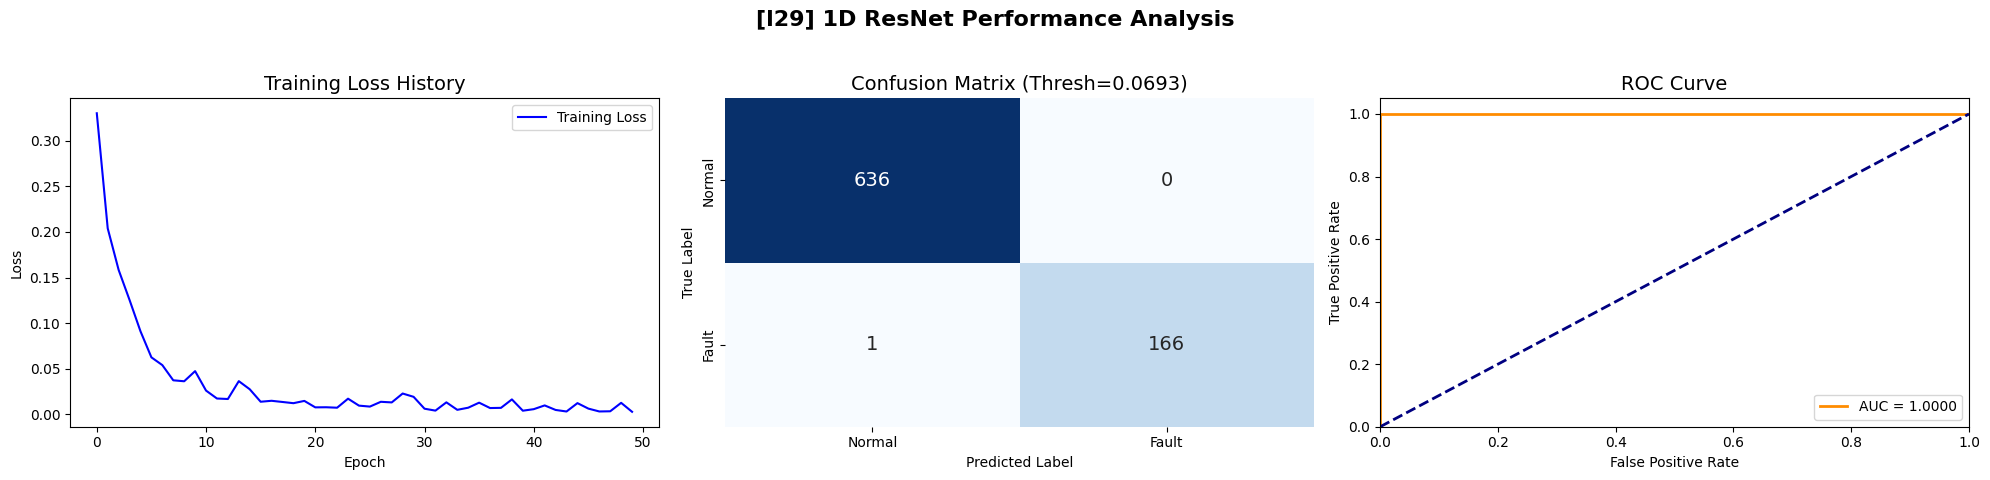


🚀 [1D ResNet] Processing Experiment: l31
  - Total Normal: 3311, Total Fault: 488
  - Resplit Train: (3039, 10, 19), Test: (760, 10, 19)
  Epoch [10/50], Loss: 0.017261
  Epoch [20/50], Loss: 0.007204
  Epoch [30/50], Loss: 0.010567
  Epoch [40/50], Loss: 0.006340
  Epoch [50/50], Loss: 0.001807


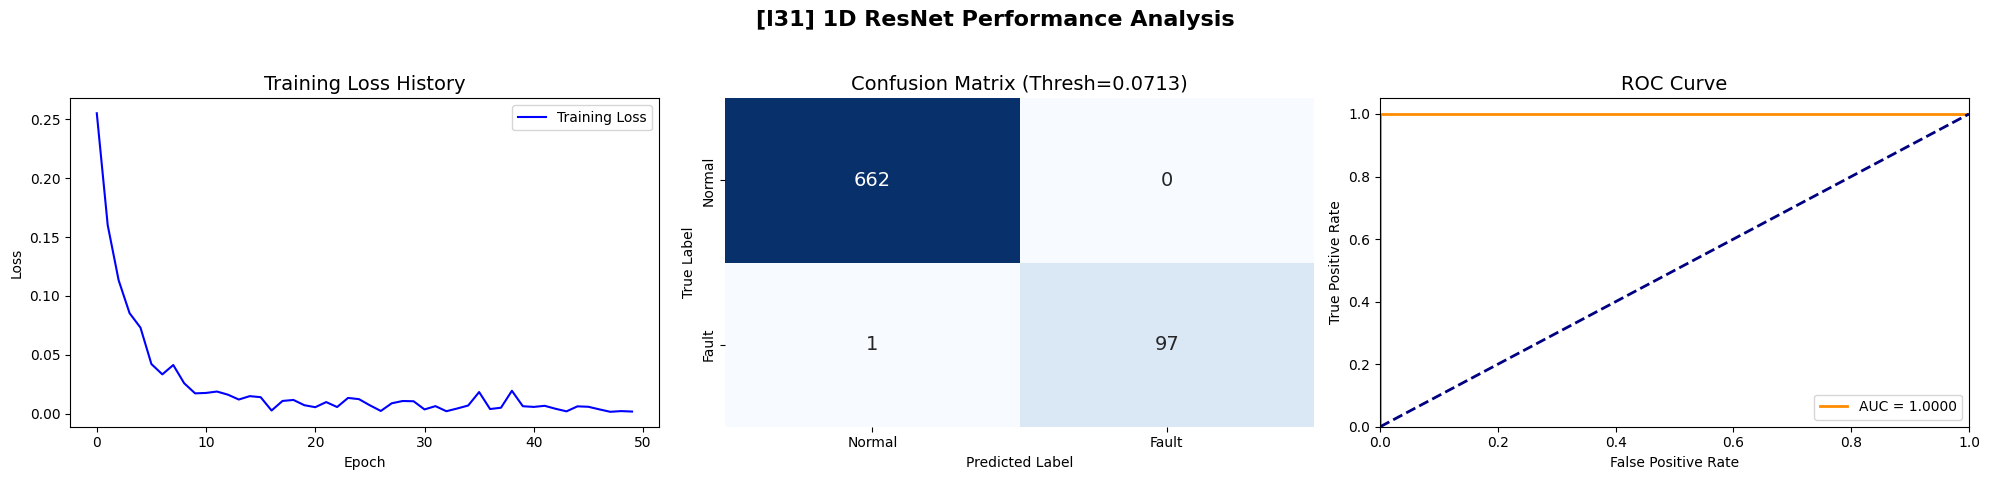


🚀 [1D ResNet] Processing Experiment: l33
  - Total Normal: 3313, Total Fault: 550
  - Resplit Train: (3090, 10, 19), Test: (773, 10, 19)
  Epoch [10/50], Loss: 0.014536
  Epoch [20/50], Loss: 0.001349
  Epoch [30/50], Loss: 0.002379
  Epoch [40/50], Loss: 0.008777
  Epoch [50/50], Loss: 0.003508


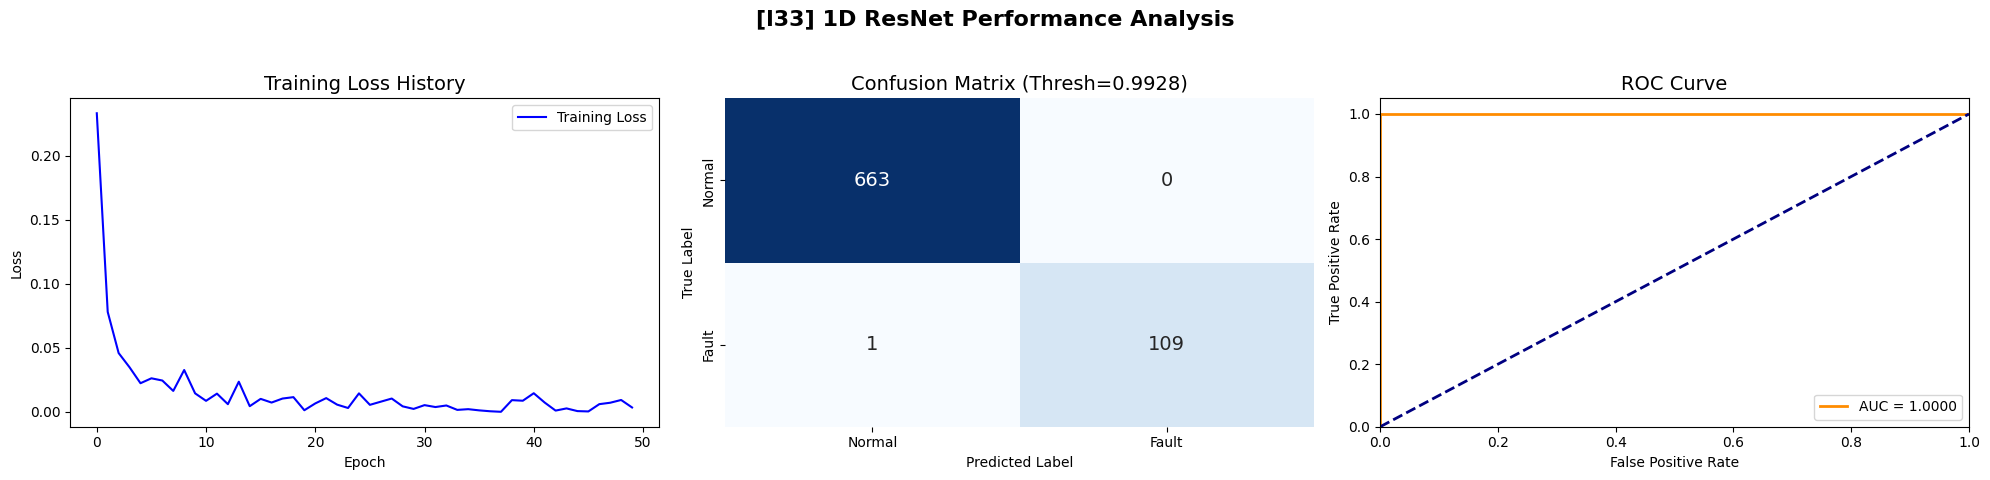


1D ResNet Final Results Summary
   Exp  AUC  F1_Score  F_Weighted  Best_Thresh
0  l29  1.0       1.0    0.998753     0.069301
1  l31  1.0       1.0    0.998681     0.071278
2  l33  1.0       1.0    0.998704     0.992809


In [13]:
#학습 코드 시작 부분에서 기존에 나뉘어 있던 정상/불량 데이터를 다시 합치고(Merge), 라벨(0/1)을 부여한 뒤, ResNet용으로 다시 나누는(Resplit) 과정을 거치도록 수정한 코드
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# ==========================================
# 1. 시각화 함수 정의
# ==========================================
def visualize_resnet_results(exp_id, train_losses, y_true, y_scores, threshold):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] 1D ResNet Performance Analysis", fontsize=16, fontweight='bold')

    # --- Plot 1: Training Loss Curve ---
    axes[0].plot(train_losses, label='Training Loss', color='blue')
    axes[0].set_title("Training Loss History", fontsize=14)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Plot 2: Confusion Matrix ---
    y_pred = (y_scores > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'], annot_kws={"size": 14})
    axes[1].set_title(f"Confusion Matrix (Thresh={threshold:.4f})", fontsize=14)
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')

    # --- Plot 3: ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title("ROC Curve", fontsize=14)
    axes[2].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==========================================
# 2. 실행 루프 (Experiment 별)
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

resnet_results = []
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EPOCHS = 50          # 학습 횟수 (필요시 조절)

for exp_id in experiments:
    if exp_id not in datasets: continue

    print(f"\n🚀 [1D ResNet] Processing Experiment: {exp_id}")
    data = datasets[exp_id]

    # -------------------------------------------------------
    # [중요] 데이터 재구성 (Data Resplit for Supervised Learning)
    # -------------------------------------------------------
    # 기존 전처리는 비지도 학습용이라 X_train에 정상 데이터만 있습니다.
    # ResNet은 불량 데이터도 학습해야 하므로, 모든 데이터를 합친 후 다시 나눕니다.

    # 1. 모든 정상 데이터 통합 (기존 Train + Test Normal)
    X_all_normal = np.concatenate([data['X_train'], data['X_test_norm']], axis=0)
    # 2. 모든 불량 데이터 (Test Fault)
    X_all_fault = data['X_test_fault']

    print(f"  - Total Normal: {len(X_all_normal)}, Total Fault: {len(X_all_fault)}")

    # 3. 라벨 생성 (Normal=0, Fault=1) - 여기서 라벨링 수행
    y_all_normal = np.zeros(len(X_all_normal))
    y_all_fault = np.ones(len(X_all_fault))

    # 4. 전체 데이터 병합
    X_total = np.concatenate([X_all_normal, X_all_fault], axis=0)
    y_total = np.concatenate([y_all_normal, y_all_fault], axis=0)

    # 5. ResNet용 Train/Test 분할 (Stratified Split: 불량 비율 유지)
    # 불량 데이터가 적기 때문에 stratify 옵션이 필수입니다.
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_total, y_total, test_size=0.2, stratify=y_total, random_state=42
        )
    except ValueError:
        print(f"  ⚠️ {exp_id}: 데이터가 너무 적어 분할할 수 없습니다. 스킵합니다.")
        continue

    print(f"  - Resplit Train: {X_train.shape}, Test: {X_test.shape}")

    # -------------------------------------------------------
    # 모델 학습 시작
    # -------------------------------------------------------
    # Tensor 변환
    train_tensor_x = torch.FloatTensor(X_train).to(device)
    train_tensor_y = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    test_tensor_x = torch.FloatTensor(X_test).to(device)
    # y_test는 나중에 평가에 사용 (Tensor 변환 불필요)

    # DataLoader 생성
    train_loader = DataLoader(TensorDataset(train_tensor_x, train_tensor_y), batch_size=BATCH_SIZE, shuffle=True)

    # 모델 초기화
    n_samples, seq_len, n_feats = X_train.shape
    model = ResNet1D(n_features=n_feats).to(device)

    criterion = nn.BCELoss() # 이진 분류 손실함수
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # --- 학습 (Training) ---
    model.train()
    train_losses = []

    for epoch in range(EPOCHS):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch+1) % 10 == 0:
            print(f"  Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")

    # --- 추론 (Inference) ---
    model.eval()
    with torch.no_grad():
        # 테스트 데이터에 대한 예측 확률값 (0~1 사이)
        y_probs = model(test_tensor_x).cpu().numpy().flatten()

    # --- 평가 (Metrics) ---
    # Precision-Recall Curve로 최적의 Threshold 찾기 (Best F1 Score 기준)
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    f1_scores = np.divide(2 * recall * precision, recall + precision + 1e-9)
    best_idx = np.argmax(f1_scores)
    # Threshold가 없는 경우(데이터가 너무 적을 때) 예외 처리
    best_thresh = thresholds[best_idx] if len(thresholds) > best_idx else 0.5
    best_f1 = f1_scores[best_idx]

    # AUC 계산
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # F-weighted Score (논문 지표) 계산
    y_pred = (y_probs > best_thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    f1_fault = tp / (tp + 0.5 * (fp + fn) + 1e-9)
    f0_normal = tn / (tn + 0.5 * (fn + fp) + 1e-9)

    n_fault = np.sum(y_test == 1)
    n_normal = np.sum(y_test == 0)

    if (n_fault + n_normal) > 0:
        f_weighted = (f1_fault * n_fault + f0_normal * n_normal) / (n_fault + n_normal)
    else:
        f_weighted = 0.0

    resnet_results.append({
        'Exp': exp_id,
        'AUC': roc_auc,
        'F1_Score': best_f1,
        'F_Weighted': f_weighted,
        'Best_Thresh': best_thresh
    })

    # --- 시각화 ---
    visualize_resnet_results(exp_id, train_losses, y_test, y_probs, best_thresh)

# 결과 요약 출력
print("\n" + "="*50)
print("1D ResNet Final Results Summary")
print("="*50)
df_res = pd.DataFrame(resnet_results)
print(df_res)